In [28]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder as ohe
import cv2

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.autograd import Variable

In [29]:
#To make use of GPU for training and processing
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [30]:
#Getting the data from CSV to padas dataframe
data = pd.read_csv('D:\\Drive D\Github\\important-files\\Machine Learning\\Projects\\Computer Vision\\2. License Plate Recognition\\data\\original\\trainVal.csv')
data

,track_id,image_path,lp,train
0,s01_l01_1,s01_l01/1_1.png,7C24698,1
1,s01_l01_2,s01_l01/2_1.png,7C24698,1
2,s01_l01_2,s01_l01/2_2.png,7C24698,1
3,s01_l01_2,s01_l01/2_3.png,7C24698,1
4,s01_l01_2,s01_l01/2_4.png,7C24698,1
...,...,...,...,...
182331,s04_l02_2761,s04_l02/2761_15.png,1BB0874,0
182332,s04_l02_2761,s04_l02/2761_16.png,1BB0874,0
182333,s04_l02_2761,s04_l02/2761_17.png,1BB0874,0
182334,s04_l02_2761,s04_l02/2761_18.png,1BB0874,0


In [31]:
#Checking if there're any null values in the data
data.isnull().sum()

track_id      0
image_path    0
lp            0
train         0
dtype: int64

In [32]:
#Splitting the dataframe into train and test sets
X_train = data[data['train'] == 1].drop(['lp'], axis=1)
y_train = data[data['train'] == 1][['lp']]

X_test = data[data['train'] == 0].drop(['lp'], axis=1)
y_test = data[data['train'] == 0][['lp']]


In [33]:
#Constructing a dataloader in order to iterate over the data
from torch.utils.data import Dataset, DataLoader

class LPDataset(Dataset):

    def __init__(self, X_train, y_train, root_dir, transform=None):

        self.X = X_train.iloc[:,1:2]
        self.y = y_train.values
        self.root_dir = root_dir
        self.transform = transform
        self.string = 'abcdefghijklmnopqrstuvwxyz0123456789'

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img_path = self.X.iloc[idx, 0]
        #img_path = str(img_path).replace("./","/")

        image_name = self.root_dir + img_path

        image = mpimg.imread(image_name)
        
        # if image has an alpha color channel, get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        y = self.y[idx]

        #One Hot Encoder custom implementation
        text = y[0]
        alphanumeric = dict((c, i) for i, c in enumerate(self.string))
        string_no = [alphanumeric[char] for char in text.lower()]
        ohe = list()
        char_2_int = []
        for char in string_no:
            z_ohe = [0 for _ in range(len(self.string))]
            z_ohe[char] = 1
            ohe.append(z_ohe)
        ohe = np.asarray(ohe) #outputs the one hot encoding in the form of 2D matrix
        lpno = ohe
        sample = {'image': image, 'lpno': lpno}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [34]:
root_dir = "data/original/"
dataset = LPDataset(X_train, y_train, root_dir)

print('Length of dataset: ', len(dataset))

Length of dataset:  105924


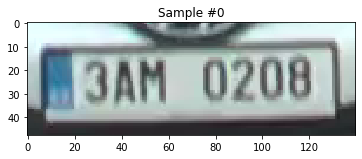

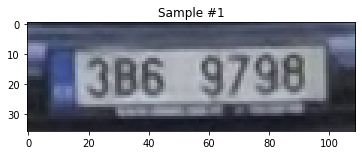

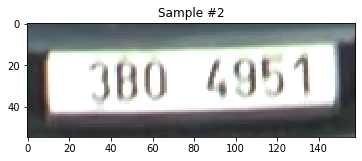

In [35]:
#display few images
num_to_display = 3
for i in range(num_to_display):
    
    # define the size of images
    fig = plt.figure(figsize=(20,10))
    
    # randomly select a sample
    rand_i = np.random.randint(0, len(dataset))
    sample = dataset[rand_i]

    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(i))
    
    # view image
    plt.imshow(sample["image"])

In [36]:
class ToTensor(object):
    #to convert an object into torch tensor

    def __call__(self, sample):
        image, lpno = sample['image'], sample['lpno']

        if(len(image.shape) == 2):

            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'lpno': torch.from_numpy(lpno)}

class Rescale(object):
    #to rescale the images in order to make sure that they are of consistence size

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, lpno = sample['image'], sample['lpno']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))

        return {'image': img, 'lpno': lpno}


In [37]:
data_transform = transforms.Compose([Rescale(200),
                                     ToTensor()])
root_dir = "data/original/"
transformed_dataset = LPDataset(X_train, y_train, root_dir,transform=data_transform)

In [38]:
for i in range(5):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['lpno'].size())

0 torch.Size([3, 200, 625]) torch.Size([7, 36])
1 torch.Size([3, 200, 625]) torch.Size([7, 36])
2 torch.Size([3, 200, 625]) torch.Size([7, 36])
3 torch.Size([3, 200, 625]) torch.Size([7, 36])
4 torch.Size([3, 200, 625]) torch.Size([7, 36])


In [39]:
batch_size = 30

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)
print("Train size: ", len(transformed_dataset))

transformed_dataset = LPDataset(X_test, y_test, root_dir,transform=data_transform)
print("Test size: ", len(transformed_dataset))

test_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

Train size:  105924
Test size:  76412


In [40]:
for i in range(5):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['lpno'].size())

0 torch.Size([3, 200, 610]) torch.Size([7, 36])
1 torch.Size([3, 200, 605]) torch.Size([7, 36])
2 torch.Size([3, 200, 595]) torch.Size([7, 36])
3 torch.Size([3, 200, 600]) torch.Size([7, 36])
4 torch.Size([3, 200, 595]) torch.Size([7, 36])


In [41]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3) #(200,625,3)
        self.batch1 = nn.BatchNorm2d(6)
        self.pool1 = nn.MaxPool2d(2, 2) 

        self.conv2 = nn.Conv2d(16, 32, 3) #(100,312,16)
        self.batch2 = nn.BatchNorm2d(6)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(32, 64, 3) #(50,156,32)
        self.batch3 = nn.BatchNorm2d(6)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64*25*78, 128)
        self.fc2 = nn.Linear(128, 36)
        self.softmax = nn.Softmax(dim=1)
       
    def forward(self, x):
        x = self.batch1(F.relu(self.conv1(x)))
        x = self.batch1(F.relu(self.conv1(x)))
        x = self.pool1(x)

        x = self.batch2(F.relu(self.conv2(x)))
        x = self.batch2(F.relu(self.conv2(x)))
        x = self.pool2(x)

        x = self.batch3(F.relu(self.conv3(x)))
        x = self.batch3(F.relu(self.conv3(x)))
        x = self.pool3(x)

        x = x.view(-1, 64*25*78)
        
        x1 = F.relu(self.fc1(x))
        x1 = F.relu(self.fc2(x1)) 
        x1 = self.softmax(x1)

        x2 = F.relu(self.fc1(x))
        x2 = F.relu(self.fc2(x2)) 
        x2 = self.softmax(x2)

        x3 = F.relu(self.fc1(x))
        x3 = F.relu(self.fc2(x3)) 
        x3 = self.softmax(x3)

        x4 = F.relu(self.fc1(x))
        x4 = F.relu(self.fc2(x4)) 
        x4 = self.softmax(x4)

        x5 = F.relu(self.fc1(x))
        x5 = F.relu(self.fc2(x5)) 
        x5 = self.softmax(x5)

        x6 = F.relu(self.fc1(x))
        x6 = F.relu(self.fc2(x6)) 
        x6 = self.softmax(x6)

        x7 = F.relu(self.fc1(x))
        x7 = F.relu(self.fc2(x7)) 
        x7 = self.softmax(x7)

        x8 = F.relu(self.fc1(x))
        x8 = F.relu(self.fc2(x8)) 
        x8 = self.softmax(x8)
        return x1,x2,x3,x4,x5,x6,x7,x8

net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=124800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=36, bias=True)
  (softmax): Softmax(dim=1)
)


In [42]:
criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr = 0.001)

In [43]:
def train_net(n_epochs):

    net.train()

    for epoch in range(n_epochs):
        
        running_loss = 0.0

        for batch_i, data in enumerate(train_loader):
            images = data['image']
            lpno = data['lpno']

            # flatten lpno
            lpno = lpno.view(lpno.size(0), -1)

            # convert variables to floats for regression loss
            lpno = lpno.type(torch.cuda.FloatTensor)
            images = images.type(torch.cuda.FloatTensor)

            # forward pass
            output = net(images).to(device)
            output = output.type(torch.cuda.FloatTensor)
            #print("output.type", output.type())
            # calculate the loss
            loss = criterion(output, lpno)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()
            testLoss = []
            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')

In [ ]:
#training starts
ep = 50
train_net(ep)